In [1]:
import torch

from botorch.utils.sampling import draw_sobol_samples

from scalarize.test_functions.multi_objective import FourBarTrussDesign
from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
input_dim = 4
output_dim = 2

problem = FourBarTrussDesign(negate=True)
bounds = problem.bounds.to(**tkwargs)

# Get a batch of random samples.
torch.manual_seed(0)
num_samples = 128
grid_length = 32
num_points = grid_length * grid_length

b1 = torch.column_stack([bounds[:, 0], bounds[:, 2]])
b2 = torch.column_stack([bounds[:, 1], bounds[:, 3]])

g1 = torch.linspace(b1[0, 0], b1[1, 0], grid_length).to(**tkwargs)
g2 = torch.linspace(b1[0, 1], b1[1, 1], grid_length).to(**tkwargs)
X, Y = torch.meshgrid(g1, g2, indexing="xy")

X1 = []
for i in range(grid_length):
    X1 += [torch.column_stack([X[i, :], Y[i, :]])]
X1 = torch.cat(X1)
X2 = draw_sobol_samples(bounds=b2, n=num_samples, q=1, seed=2).squeeze(-2)

Ys = torch.zeros(num_samples, num_points, output_dim, **tkwargs)
Xs = torch.zeros(num_samples, num_points, input_dim, **tkwargs)
ones = torch.ones(num_points, 1, **tkwargs)

for n in range(num_samples):
    Xn = torch.column_stack(
        [
            X1[:, 0],
            X2[n, 0] * ones,
            X1[:, 1],
            X2[n, 1] * ones,
        ]
    )
    Yn = problem(Xn)

    Xs[n, ...] = Xn
    Ys[n, ...] = Yn

# Get the lengths.
num_weights = 201
nadir = 0 * torch.ones(1, output_dim, **tkwargs)
t = torch.linspace(0, 1, 201, **tkwargs).unsqueeze(-1)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(t)
scalarization_fn = LengthScalarization(weights=weights, ref_points=nadir)

# Get the Pareto fronts.
rescaled_Ys = torch.zeros(num_samples, num_points, output_dim, **tkwargs)
lengths = torch.zeros(num_samples, num_weights, **tkwargs)
fronts = torch.zeros(num_samples, num_weights, output_dim, **tkwargs)
for n in range(num_samples):
    # Rescale objective vectors to lie in the unit hypercube.
    Yn = torch.column_stack(
        [(Ys[n][:, 0] + 1400) / 1400 + 0.925, (Ys[n][:, 1] + 0.005) / 0.04 + 0.95]
    )
    lengths[n, :] = scalarization_fn(Yn).max(dim=0).values
    rescaled_Ys[n, ...] = Yn
    fronts[n, ...] = nadir + weights * lengths[n, :].unsqueeze(-1)

# Desired points.
desired_points = torch.tensor([[0.2, 0.875], [0.55, 0.675], [0.85, 0.375]], **tkwargs)

losses = []

rY = rescaled_Ys.reshape(num_samples, grid_length, grid_length, output_dim)
for i, y in enumerate(desired_points):
    s_fn = LengthScalarization(weights=y - nadir, ref_points=nadir)
    diff_norm = torch.norm(y - nadir, 2) ** 2
    loss_i = diff_norm * ((s_fn(rY) - 1) ** 2).mean(dim=0).squeeze(-1)
    losses += [loss_i]

X_flat = X.reshape(grid_length * grid_length)
Y_flat = Y.reshape(grid_length * grid_length)
best_Xs = []
best_Ys = []
for i, y in enumerate(desired_points):
    idx = losses[i].argmin()
    best_x = torch.column_stack([X_flat[idx], Y_flat[idx]]).squeeze(0)

    best_Xs += [(best_x - b1[0]) / (b1[1] - b1[0])]
    best_Ys += [rescaled_Ys[:, idx, :]]

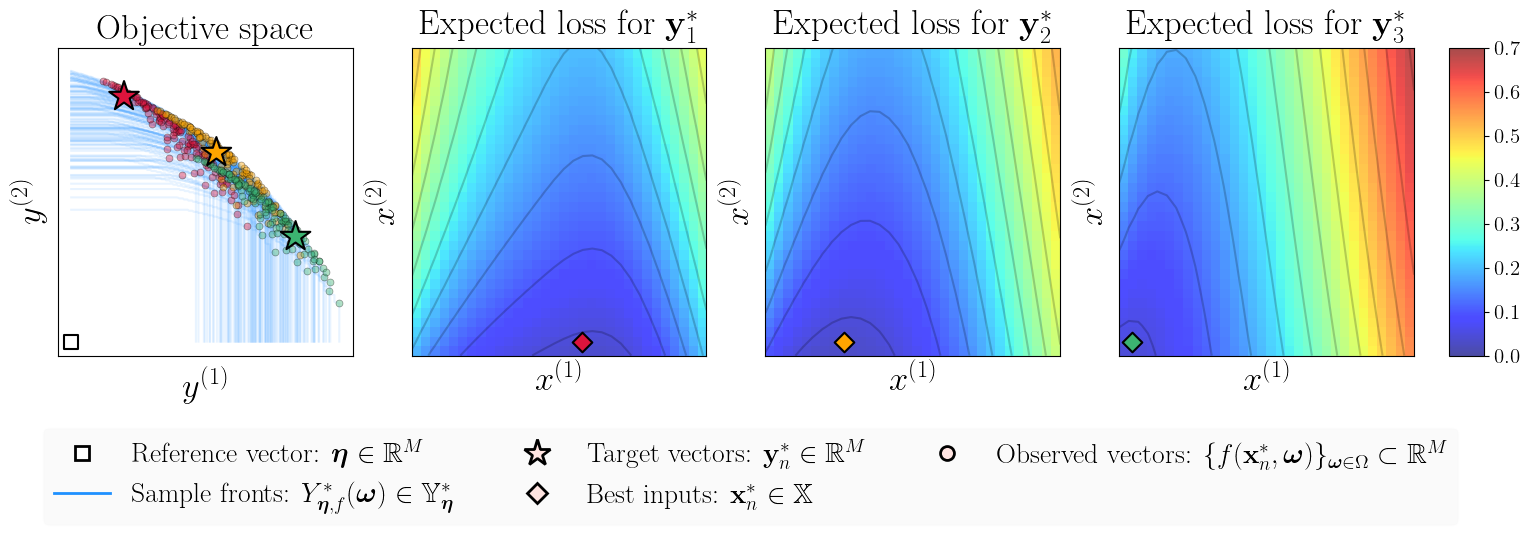

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(17.5, 4), rasterized=True)

ax = plt.subplot(1, 4, 1)

ax.scatter(
    nadir[:, 0],
    nadir[:, 1],
    color="w",
    marker="s",
    linestyle="None",
    s=100,
    edgecolors="k",
    linewidth=1.5,
    zorder=5,
)

for n in range(num_samples):
    ax.plot(fronts[n, :, 0], fronts[n, :, 1], color="dodgerblue", alpha=0.1)

colors = ["crimson", "orange", "mediumseagreen"]
ax.scatter(
    desired_points[:, 0],
    desired_points[:, 1],
    color=colors,
    marker="*",
    s=500,
    edgecolor="k",
    linewidth=1.5,
    zorder=5,
)

for i in range(len(desired_points)):
    ax.scatter(
        best_Ys[i][:, 0],
        best_Ys[i][:, 1],
        color=colors[i],
        marker="o",
        s=25,
        edgecolor="k",
        linewidth=0.5,
        zorder=4,
        alpha=0.4,
    )

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r"$y^{(1)}$", fontsize=25)
ax.set_ylabel(r"$y^{(2)}$", fontsize=25)
ax.set_ylim([-0.05, 1.05])
ax.set_title("Objective space", fontsize=25)
####################################################################################
# Inputs
g = torch.linspace(-0.05, 1.1, grid_length).to(**tkwargs)
Z1, Z2 = torch.meshgrid(g, g, indexing="xy")
for i in range(len(desired_points)):
    ax = plt.subplot(1, 4, 2 + i)
    ax.contour(Z1, Z2, losses[i], colors="black", alpha=0.2, levels=10)
    ax.imshow(
        losses[i],
        extent=[-0.05, 1.1, -0.05, 1.1],
        origin="lower",
        cmap="jet",
        alpha=0.7,
        vmin=0.0,
        vmax=0.7,
        aspect="auto",
    )

    ax.scatter(
        best_Xs[i][0],
        best_Xs[i][1],
        color=colors[i],
        marker="D",
        s=100,
        edgecolor="k",
        linewidth=1.5,
        zorder=5,
    )

    ax.set_title(rf"Expected loss for $\mathbf{{y}}^*_{i+1}$", fontsize=25, pad=10)
    ax.set_xlabel(r"$x^{(1)}$", fontsize=25)
    ax.set_ylabel(r"$x^{(2)}$", fontsize=25)
    ax.set_xticks([])
    ax.set_yticks([])

# Colourbar.
cmap = plt.get_cmap("jet")
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=0.7)
ax_bar = fig.add_axes([0.92, 0.11, 0.02, 0.77])
cbar = matplotlib.colorbar.ColorbarBase(
    ax_bar,
    cmap=cmap,
    spacing="proportional",
    orientation="vertical",
    norm=norm,
)
cbar.ax.tick_params(labelsize=15)
cbar.solids.set(alpha=0.7)
####################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

blue_line = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    linestyle="-",
    linewidth=2,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Sample fronts: $Y_{\boldsymbol{\eta}, f}^*(\boldsymbol{\omega}) \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
)

white_star = mlines.Line2D(
    [],
    [],
    color="mistyrose",
    marker="*",
    linestyle="None",
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Target vectors: $\mathbf{y}_{n}^* \in \mathbb{R}^M$",
)
white_diamond = mlines.Line2D(
    [],
    [],
    color="mistyrose",
    marker="D",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Best inputs: $\mathbf{{x}}_{n}^* \in \mathbb{X}$",
)
white_point = mlines.Line2D(
    [],
    [],
    color="mistyrose",
    marker="o",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Observed vectors: $\{f(\mathbf{{x}}_{n}^*, \boldsymbol{\omega})\}_{\boldsymbol{\omega} \in \Omega} \subset \mathbb{R}^M$",
)

axes[0].legend(
    handles=[
        white_square,
        blue_line,
        white_star,
        white_diamond,
        white_point,
    ],
    ncol=3,
    fontsize=20,
    loc=(-0.05, -0.55),
    facecolor="k",
    framealpha=0.02,
)

plt.show()